In [1]:
'''
Explantion of split_count_select()
Splits a large image into subimages of equal size (have to give it a number of subimages to split into).
For each subimage:
1. Performs Otsu threshold and uses results to determine blocksize and iterations.
2. Performs adaptive thresholding using selected blocksize and iterations. Removes noise.
3. Calculates a score for the result based on scale size variation and uniformity of distribution.
The lower the score, the better.
4. If the score is too high, repeat steps 1-3 on inverted image and see if the score for the inverted
image is lower. Keep the one with lower score.

Finally, choose the 3 subimages with the lowest (best) scores (printed in a list at the bottom as SELECTED SUBIMAGES)

Explantion of run_count_on_directory()
Does the same as split_count_select but does not split images and therefore does not choose best segments.

'''

'\nExplantion of split_count_select()\nSplits a large image into subimages of equal size (have to give it a number of subimages to split into).\nFor each subimage:\n1. Performs Otsu threshold and uses results to determine blocksize and iterations.\n2. Performs adaptive thresholding using selected blocksize and iterations. Removes noise.\n3. Calculates a score for the result based on scale size variation and uniformity of distribution.\nThe lower the score, the better.\n4. If the score is too high, repeat steps 1-3 on inverted image and see if the score for the inverted\nimage is lower. Keep the one with lower score.\n\nFinally, choose the 3 subimages with the lowest (best) scores (printed in a list at the bottom as SELECTED SUBIMAGES)\n\nExplantion of run_count_on_directory()\nDoes the same as split_count_select but does not split images and therefore does not choose best segments.\n\n'

In [2]:
import cv2
import numpy as np
from datascience import *
import matplotlib as mpl
from matplotlib import pyplot as plt
import sys
import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 120
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
import pandas
import statistics
import image_slicer

#plt.subplots_adjust(left=1, bottom=1, right=1, top=1, wspace=.9, hspace=1)

img_names = []
count_list = []
quality_list = []
image_size_split = []

In [3]:
#perhaps we could make a distribution of distances as well looking at distance between all points

from scipy.spatial.distance import pdist as pdist


#perhaps we can only look at close scales that are of similar size
def dist_dist(c):
    dm = pdist(c, 'euclidean')

def shortest_distance(n, c):
    min_dis = np.inf
    for i in c:
        if (i[0] != n[0] and i[1] != n[1]) and sum((n - i)**2)**.5 < min_dis :
             min_dis = sum((n - i)**2)**.5 
    return min_dis


def avg_shortest_distance(centroids):
    #This goes through and looks at the avg distance between the scales.
    index = 0
    
    shortest_dis = []
    #iterates through every center
    for i in np.arange(0, len(centroids)):
        c = centroids[i]
        #for the given center then compare to all the other c
        shortest_dis.append(shortest_distance(c, centroids))
        
    print("avg shortest distance", np.std(shortest_dis), np.mean(shortest_dis))
    return np.std(shortest_dis), np.mean(shortest_dis)



In [4]:
distance_standard_deviations = []
average_shortest_distances_squared = []

In [5]:
def threshold_otsu(img):
    '''Parameter img should already have been read by cv2 and converted to grayscale.
    Returns sure foreground of image thresholded using Otsu.'''
    # Apply blur
    blur = cv2.GaussianBlur(img,(5,5),1)
    blur = cv2.GaussianBlur(img,(5,5),1)


    # Threshold image using Otsu
    ret, thresh = cv2.threshold(blur,0 , 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    # Perform opening on thresholded image
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 4)

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform, .25, 255, 0)
    
#     plt.imshow(thresh, 'gray')
#     plt.show()
    return sure_fg

In [6]:
def choose_blocksize_and_iterations(img):
    '''Parameter img should be the sure foreground of the Otsu-thresholded image.
    Returns selected blocksize and iterations.'''
    
    # Collect stats from image
    binary_map = (img > 0).astype(np.uint8)
    connectivity = 4 # can be changed
    output = cv2.connectedComponentsWithStats(binary_map, connectivity, cv2.CV_32S)
   
    num_labels = output[0]
    labels = output[1]
    stats = output[2]
    centroids = output[3]
    
    avg_scale_size = np.average(stats[1:,-1])
    
    #added this line of code to find "uniformity"
    distance_std, avg_shortest_dis_squared = avg_shortest_distance(centroids)
    distance_standard_deviations.append(distance_std)
    
    dist_dist(centroids)
    
    average_shortest_distances_squared.append(avg_shortest_dis_squared)
    
    
    print('Block size from formula:', avg_shortest_dis_squared + np.sqrt(avg_scale_size) + int(.214*np.sqrt(avg_scale_size)))
    
    block_size = int(avg_shortest_dis_squared + np.sqrt(avg_scale_size) + int(.214*np.sqrt(avg_scale_size))/2)
    
    iterations = 0 
    
    if block_size % 2 == 0:
        block_size = block_size + 1
    
    if block_size > 85:
        iterations = 1
    else:
        iterations = min(int(block_size/15), 3)
        
    return block_size, iterations


#     if num_labels <= 3:
#         return 15, 1
#     elif avg_scale_size < 350:
#         return 65, 2
#     elif avg_scale_size < 550:
#         return 65, 3
#     else:
#         return 85, 1

In [23]:
def threshold_adaptive(img, blocksize, iterations):
    '''Parameter img should already have been read by cv2 and converted to grayscale.
    Performs adaptive thresholding on img using given blocksize and iterations.
    Returns resulting:
        -sure foreground with noise (for displaying purposes)
        -noise-removed image with scales labeled
        -scale count'''
    
    odd_median_blur_value = int(blocksize/2)
    if odd_median_blur_value %2 == 0:
        odd_median_blur_value = odd_median_blur_value + 1
    cv2.medianBlur(img, odd_median_blur_value)

    if (blocksize > 15):
        #blur = cv2.GaussianBlur(img,(5,5),1)
        blur = cv2.bilateralFilter(img,10,10,200)
        #could make more specific to be distance - scale size 
        #cv2.medianBlur(img, 5)
    
    else:
        #blur = cv2.medianBlur(img, 5)
        blur = cv2.GaussianBlur(img,(5,5),0)

        
    # Collect stats from thresh image

    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, blocksize, -2)
    
#     print('Adaptive Thresholding')
#     plt.imshow(thresh, 'gray')
#     plt.show()
    
    binary_map = (thresh > 0).astype(np.uint8)
    connectivity = 4 # can be changed
    output = cv2.connectedComponentsWithStats(binary_map, connectivity, cv2.CV_32S)
   
    num_labels = output[0]
    labels = output[1]
    stats = output[2]
    centroids = output[3]
    
    scale_sizes = np.copy(stats[1:,-1]) # start from 1 instead of 0 to ignore background, use copy so that stats array doesn't get modified
    scale_sizes.sort() # sort the list of scale sizes from smallest to largest
    avg_scale_size = np.average(scale_sizes[len(scale_sizes) // 2:]) # average size among the largest half of the scales
    

    
    #
    
    thresh2 = cv2.bitwise_not(thresh)
    contour,hier = cv2.findContours(thresh2 ,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contour:
        if cv2.contourArea(cnt) < avg_scale_size/5:
            thresh2 = cv2.drawContours(thresh2, [cnt], -1, (0,0,0), -1)

    thresh = cv2.bitwise_not(thresh2)

#     print('Filling Holes')
#     plt.imshow(thresh, 'gray')
#     plt.show()
    
    #adding

    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = iterations)

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform, 1.5 , 255, 0) 

    # Collect stats from sure_foreground image
    binary_map = (sure_fg > 0).astype(np.uint8)
    connectivity = 4 # can be changed
    output = cv2.connectedComponentsWithStats(binary_map, connectivity, cv2.CV_32S)
   
    num_labels = output[0]
    labels = output[1]
    stats = output[2]
    centroids = output[3]
    
    scale_sizes = np.copy(stats[1:,-1]) # start from 1 instead of 0 to ignore background, use copy so that stats array doesn't get modified
    scale_sizes.sort() # sort the list of scale sizes from smallest to largest
    avg_scale_size = np.average(scale_sizes[len(scale_sizes) // 2:]) # average size among the largest half of the scales
    
    # Remove the identified noise
        # Removing noise
    for i in range(num_labels):
        # If a scale is smaller than 1/10 the average among the largest half of the scales
        if stats[i, cv2.CC_STAT_AREA] < (avg_scale_size / 3):
            noise_left = stats[i, cv2.CC_STAT_LEFT]
            noise_top = stats[i, cv2.CC_STAT_TOP]
            # Go through the bounding box of the noise and find all the pixels that are part of the noise
            for x in range(noise_left, noise_left + stats[i, cv2.CC_STAT_WIDTH]):
                for y in range(noise_top, noise_top + stats[i, cv2.CC_STAT_HEIGHT]):
                    if labels[y][x] == i: # If the pixel is part of the noise
                        labels[y][x] = 0 # Remove the noise by replacing the pixel with the background label
            num_labels -= 1
    # Note: Noise has been removed from labels matrix, but the noise is still in stats/centroids matrices.
    # This is ok because we don't use these outdated stats/centroids matrices again (in later functions, we create updated stats matrices by calling connected components again on the noise-removed image.)
    
    
    # Label and count
    # source: https://medium.com/analytics-vidhya/images-processing-segmentation-and-objects-counting-in-an-image-with-python-and-opencv-216cd38aca8e
    label_hue = np.uint8(179 * labels / np.max(labels))
    blank_ch = 255 * np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
    labeled_img[label_hue == 0] = 0

    return sure_fg, blur, labeled_img, num_labels - 1 # background doesn't count as a scale

In [24]:
def overlay(bw_img, color_mask, w1=0.2, w2=0.95):
    a = cv2.cvtColor(bw_img, cv2.COLOR_GRAY2RGB)
    a -= np.min(a)
    a = a/np.max(a)*255
    a = np.clip(a, a_min=0, a_max=255).astype(int)
    b = np.clip(color_mask, a_min=0, a_max=255).astype(int)
    c = cv2.addWeighted(b,w1,a,w2,0)
    return c

In [25]:
def display_results_orig(orig, blurred_img, with_noise, noise_removed, count):

    plt.subplot(1,5,1), plt.imshow(orig, 'gray')
    plt.title("Orginal Grayscale", fontsize=5)
    plt.tight_layout()

    plt.subplot(1,5,2), plt.imshow(blurred_img, 'gray')
    plt.title("Blurred Image", fontsize=5)
    plt.tight_layout()

    plt.subplot(1,5,3), plt.imshow(with_noise, 'gray')
    plt.title("With Noise", fontsize=5)
    plt.tight_layout()

    plt.subplot(1,5,4), plt.imshow(noise_removed, 'gray')
    plt.title("Noise-Removed, Count = " + str(count), fontsize=5)
    plt.tight_layout()

    plt.subplot(1,5,5), plt.imshow(overlay(orig, noise_removed))
    plt.title("Noise-Removed, Count = " + str(count), fontsize=5)
    plt.tight_layout()
    plt.show()
    
def display_results_invert(orig, invert, with_noise, noise_removed, count):
    plt.subplot(1,4,1), plt.imshow(orig, 'gray')
    plt.title("Orginal Grayscale", fontsize=5)
    plt.subplot(1,4,2), plt.imshow(invert, 'gray')
    plt.title("Inverted", fontsize=5)
    plt.subplot(1,4,3), plt.imshow(with_noise, 'gray')
    plt.title("Inverted With Noise", fontsize=5)
    plt.subplot(1,4,4), plt.imshow(noise_removed, 'gray')
    plt.title("Inverted Noise-Removed, Count = " + str(count), fontsize=5)
    plt.show()

In [26]:
def calculate_score(img):
    '''Parameter img should already have scales labeled.
    Calculates and returns score based on average scale size variation and uniformity of scale distribution.
    THE LOWER THE SCORE, THE BETTER.'''
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    binary_map = (img > 0).astype(np.uint8) # make the labeled image binary (make everything that is not black be white)
    
    # we need to collect new data on connected components (rather than using previous stats array) because the noise-removal method in threshold_custom changed the image but not the stats array
    output = cv2.connectedComponentsWithStats(binary_map, 4, cv2.CV_32S)
    num_labels = output[0]
    labels = output[1]
    stats = output[2]
    centroids = output[3]
    
    # if there's less than 3 scales (num_labels = num_scales + 1 b/c of background), the checks won't work because standard deviation requires at least 2 points (two distances for distribution function)
    # Result is probably bad if there's zero or 1 scale, but I'm not sure about 2...
    if num_labels <= 3:
        return 100 #this is a random high value I chose to show that the result is not good
    
    size_var = scale_size_variation(num_labels, stats, len(img), len(img[0]))
    dis = distribution(num_labels, centroids)
    
    #Decided not to use overlap/fullness/squareness, but kept them here in comments just in case
    #overlap = overlap_of_bounds(num_labels, stats, len(img), len(img[0])) #bounding box overlap not that useful - maybe only use to eliminate if extremely high, like > 1?
    #fullness, squareness = fullness_and_squareness(num_labels, stats, len(img), len(img[0]))
    
    print("Size variation: " + str(size_var))
    #print("Overlap: " + str(overlap))
    #print("Fullness: " + str(fullness))
    #print("Squareness: " + str(squareness))
    print("Distribution: " + str(dis))
    
    score = (size_var + dis) / 2 # score is the average of size variation and distribution
    print("Overall score: " + str(score))

    return score

    
def bounding_box_edges(i, stats):
    '''Returns coordinates of edges of the bounding box at index i in stats array'''
    left = stats[i, cv2.CC_STAT_LEFT]
    right = left + stats[i, cv2.CC_STAT_WIDTH] - 1
    top = stats[i, cv2.CC_STAT_TOP]
    bottom = top + stats[i, cv2.CC_STAT_HEIGHT] - 1
    return left, right, top, bottom
        
def scale_size_variation(num_labels, stats, img_len, img_width):
    '''Returns average variation in scale size, calculated without edge scales (except in the case where there are not enough non-edge scales).
    High variation likely corresponds to poor quality results.
    Result is considered very good if return value is less than 1.
    Only works if there is at least 2 scales.''' # add assertion error check for this?
    scale_areas = []
    edge_scale_areas = []
    for i in range(1, num_labels): # start at 1 to ignore background
        
        # don't consider scales that touch the edge
        left, right, top, bottom = bounding_box_edges(i, stats)
        if left == 0 or top == 0 or right == img_width - 1 or bottom == img_len - 1:
            edge_scale_areas.append(stats[i, cv2.CC_STAT_AREA].astype(int))
            continue
            
        scale_areas.append(stats[i, cv2.CC_STAT_AREA].astype(int))

    # if 1 or zero non-edge scales, then use edge scales in calculation (otherwise, do not use edge scales)
    if len(scale_areas) < 2:
        scale_areas = scale_areas + edge_scale_areas
        
    stddev = statistics.stdev(scale_areas)
    mean = sum(scale_areas) / len(scale_areas)
    #print("(Std dev / mean) for scale area: " + str(stddev / mean))

    for edge_scale_area in edge_scale_areas: # if any of the edge scales are more than five times the average size of the non-edge scales, this is bad
        if edge_scale_area > 5*mean:
            return 100 # this is bad so return a really high value

    # thresholding good if return value less than 1
    return (stddev / mean) # figure out if dividing by mean makes any sense

def distribution(num_labels, centroids):
    '''Calculates and returns the standard deviation of the distances between the centroids of neighboring scales.
    The lower the return value, the more uniform the distribution of scales.
    Only works if there is at least 3 scales (2 distances to compare)''' # add assertion error check for this?
    x_values = []
    y_values = []
    for i in range(1, num_labels):
        x_values.append(centroids[i, 0])
        y_values.append(centroids[i, 1])
    x_values.sort()
    y_values.sort()
    
    x_diff = []
    y_diff = []
    for i in range(1, len(x_values)):
        x_diff.append(x_values[i] - x_values[i-1]) # differences between neighboring x-coordinates
        y_diff.append(y_values[i] - y_values[i-1]) # differences between neighboring y-coordinates
    
    x_stddev = statistics.stdev(x_diff)
    y_stddev = statistics.stdev(y_diff)
    avg_stddev = (x_stddev + y_stddev) / 2
    return avg_stddev

# ***Currently not used***
# Not used because most images have little overlap of bounds, regardless of how good the thresholding is
def overlap_of_bounds(num_labels, stats, img_len, img_width):
    '''Returns average overlap of the bounding boxes of the scales.
    More overlap suggests that the identified scales are not localized; rather, they weave around one another.
    Result is considered good if return value is less than 0.63.'''
    if num_labels < 2: # return None if no scales
        return
    #check for overlappingness of bounding boxes
    overlap_array = np.zeros((img_len, img_width))
    for i in range(1, num_labels): # start at 1 to ignore background
        left, right, top, bottom = bounding_box_edges(i, stats)
        for r in range(top, bottom + 1):
            for c in range(left, right + 1):
                overlap_array[r, c] += 1
    avg_overlap = np.average(overlap_array)
    #print("Avg bounding box overlap: " + str(avg_overlap))
    percent_overlap = np.count_nonzero(overlap_array > 1) / np.size(overlap_array)
    
    # thresholding good if return value less than 0.63
    return avg_overlap

# ***Currently not used***
# Produces inconsistent results (often wrong)
def fullness_and_squareness(num_labels, stats, img_len, img_width):
    '''Returns average fullness and squareness of the scales.
    Fullness is the ratio of the area of the scale to the area of the bounding box.
    Squareness is the ratio width:length of the bounding box.
    Greater fullness suggests that the scale is solid and full rather than webbed or full of holes.
    Greater squareness suggests that the scale is square/circular rather than long and skinny.
    Results considered good if fullness > 0.7 and squareness > 0.5.'''
    squareness = []
    fullness = []
    for i in range(1, num_labels):
        
        left, right, top, bottom = bounding_box_edges(i, stats)
        # don't consider scales that touch the edge
        if left == 0 or top == 0 or right == img_width - 1 or bottom == img_len - 1:
            continue
            
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        squareness.append(min(w, h) / max(w, h)) # closer to 1 means more square, smaller than 1 means less square
        
        scale_area = stats[i, cv2.CC_STAT_AREA]
        box_area = w * h
        fullness.append(scale_area / box_area)
    if fullness:
        avg_fullness = sum(fullness) / len(fullness)
        #print("Avg fullness: " + str(avg_fullness))
        squareness.sort()
        least_square = squareness[:10]
        avg_squareness = sum(least_square) / len(least_square)
        #print("Avg squareness of 10 least square scales: " + str(avg_squareness))
    
        # thresholding good if fullness > 0.7 and squareness > 0.5
        return avg_fullness, avg_squareness
    else:
        return None, None
    # returns None if no non-edge scales

In [27]:
def compare_results(score_list, num_to_keep):
    '''Compares the scores from different thresholding attempts and returns the indices corresponding to the best one(s).
    The second return value is a boolean indicating whether the best result passes a quality-check.
    Parameters: score_list is a list of scores for each image from calculate_score,
    num_to_keep is the number of images that we want to keep.'''
    
    # Return the indices corresponding to the best results - remember, the lower the score, the better
    best_indices = []
    for i in range(len(score_list)):
        if len(best_indices) < num_to_keep:
            best_indices.append(i)
        else:
            current_worst_score = max([score_list[i] for i in best_indices])
            if score_list[i] < current_worst_score: # if the score is better than the previous scores
                best_indices.remove(score_list.index(current_worst_score)) # remove the index corresponding to lowest score
                best_indices.append(i)
    
    # if any of the selected images have poor quality, say so
    for i in best_indices:
        if score_list[i] > 5: # if the score is too high (change this value later)
            print("Could not find " + str(num_to_keep) + " subimages that pass the quality check.")
        
    return best_indices

In [28]:
def invert(img):
    '''Inverts a grayscale image.'''
    return cv2.bitwise_not(img)

In [29]:
def count_scales(img):
    '''Parameter img must already have been read into cv2 and converted to grayscale.
    Calls threshold_otsu, then choose_blocksize_and_iterations, then threshold_adaptive.
    Returns resulting images and count.'''
    img_otsu = threshold_otsu(img)
    blocksize, iterations = choose_blocksize_and_iterations(img_otsu)
    print("Blocksize, iterations: " + str(blocksize) + ", " + str(iterations))
    with_noise, blurred_img, labeled_img, count = threshold_adaptive(img, blocksize, iterations)
    return with_noise, blurred_img, labeled_img, count

In [30]:
def call_count_scales_and_check_inversion(img):
    '''Main function that calls all the other functions.
    Parameter img should have already been read into cv2.
    Counts scales on original image, checks result, and counts scales on inverted image if needed.
    Finally, compares results from original vs. inverted image, and displays results from the better one.'''
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    print("Original Image:")
    # count scales on original image
    with_noise, blurred_img, labeled_img, count = count_scales(img)
    
    # check how good the results are
    orig_score = calculate_score(labeled_img)
    

    # If the result is good, display results and finish
    if orig_score < 3:
        print("\nOriginal image passed all tests; did not need to check inverted.")
        display_results_orig(img, blurred_img, with_noise, labeled_img, count)
        best_labeled_image = labeled_img
        return count, orig_score, best_labeled_image

    # Otherwise, try inverted image and compare results to original
    else:
        # save the original results in lists for later use
        result_images = [[img, with_noise, labeled_img, count]]
    
        # invert image
        inverted_img = invert(img)
    
        # count scales on inverted image
        print('\nInverted Image:')
        with_noise, inverted_blurred_img, labeled_img, count = count_scales(inverted_img)
    
        # check how good the new results are
        inverted_score = calculate_score(labeled_img)
        score_list = [orig_score, inverted_score]
        
        # compare the results from original and inverted images
        best_index = compare_results(score_list, 1)
        best_index = best_index[0]
    
        
        if best_index == 0:
            print("\nTried both original and inverted, but decided to keep original.")
            best_labeled_image = result_images[0][2]
            display_results_orig(result_images[0][0],  blurred_img, result_images[0][1],best_labeled_image, result_images[0][3])
        elif best_index == 1:
            print("\nDECIDED TO USE INVERTED IMAGE.")
            best_labeled_image = labeled_img
            display_results_invert(img, inverted_img, with_noise, best_labeled_image, count)
        
        return count, score_list[best_index], best_labeled_image

In [31]:
def run_count_on_directory(dirname):
    '''Calls call_count_scales_and_check_inversion function on every image in the given directory.'''
    directory = os.scandir(dirname)
    
    for img in directory:
        if (img.name == '.ipynb_checkpoints' or img.name == '.DS_Store'): # need to figure how to remove these files
            continue
        img_names.append(img.name)
        print(img.name)
        img_arr = cv2.imread(dirname + img.name)
        count, score_list, best_labeled_image = call_count_scales_and_check_inversion(img_arr)

#     table = Table().with_columns("Img Name", img_names, "Number of Scales", count_list, "Passes Quality Check?", quality_list)
#     table.show()
    

In [32]:
def split_count_select(img_path, num_subimages, num_to_keep):
    '''Splits given image into subimages and selects best ones to keep. '''
    img = cv2.imread(img_path)
    img_size = img.shape
    tiles = image_slicer.slice(img_path, num_subimages)
    all_scores = []
    all_counts = []
    all_labeled = []
    i = 0
    for tile in tiles:
        print('SUBIMAGE #' + str(i) + ':\n')
        count, score_list, labeled_image = call_count_scales_and_check_inversion(np.asarray(tile.image))
        all_scores.append(score_list)
        all_counts.append(count)
        all_labeled.append(labeled_image)
        i += 1
    
    best_indices_lst = compare_results(all_scores, num_to_keep)
    
    estimated_total = estimate_total_counts(all_counts, best_indices_lst, num_subimages)
    print('ESTIMATED TOTAL COUNT:', estimated_total, "SCALES")
    print('\n_______________________________________________')
    print('\nSELECTED SUBIMAGES: ' + str(best_indices_lst))
    
    
    for i in np.arange(num_to_keep):
        plt.subplot(1,num_to_keep,i+1), plt.imshow(all_labeled[best_indices_lst[i]], 'gray')
        plt.title("Chosen Image: " + str(best_indices_lst[i]), fontsize=5)
    plt.show()

In [33]:
def estimate_total_counts(all_counts, best_indices, sub_img):
    return (sum([all_counts[i] for i in best_indices]) * sub_img / 3)    
print('here')

here


Screenshot 2021-04-29 at 6.29.06 PM.png
Original Image:
avg shortest distance 12.191316316357376 29.219357557931225
Block size from formula: 55.196618533767136
Blocksize, iterations: 53, 3
Size variation: 0.4271605204353918
Distribution: 2.7461754322073673
Overall score: 1.5866679763213796

Original image passed all tests; did not need to check inverted.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


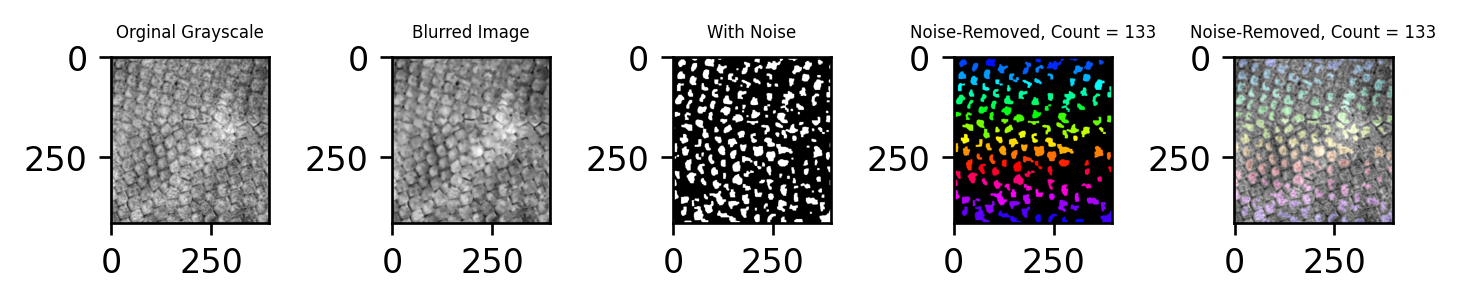

Screenshot 2021-04-29 at 6.29.16 PM.png
Original Image:
avg shortest distance 11.568897920028341 30.22927432441679
Block size from formula: 77.43019422704307
Blocksize, iterations: 73, 3
Size variation: 100
Distribution: 2.5286054288821633
Overall score: 51.26430271444108

Inverted Image:
avg shortest distance 11.419236593750172 27.452207569722372
Block size from formula: 44.84379007682782
Blocksize, iterations: 43, 2
Size variation: 100
Distribution: 21.73280291732752
Overall score: 60.86640145866376
Could not find 1 subimages that pass the quality check.

Tried both original and inverted, but decided to keep original.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


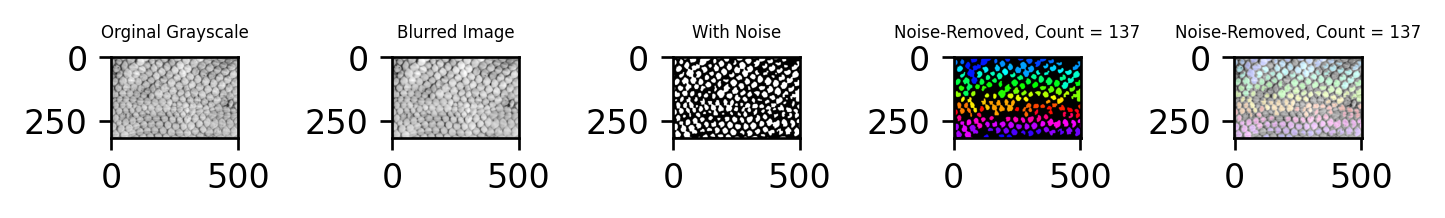

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Screenshot 2021-04-29 at 6.29.06 PM_03_03.png
Original Image:
avg shortest distance 14.327650616783762 26.26416486173677
Block size from formula: 49.39529133144576
Blocksize, iterations: 47, 3
Size variation: 0.444910094666029
Distribution: 7.984144395954562
Overall score: 4.214527245310296

Inverted Image:
avg shortest distance 5.420934637669213 25.043443152352474
Block size from formula: 44.454821319140706
Blocksize, iterations: 43, 2
Size variation: 100
Distribution: 15.951604735529994
Overall score: 57.975802367765

Tried both original and inverted, but decided to keep original.


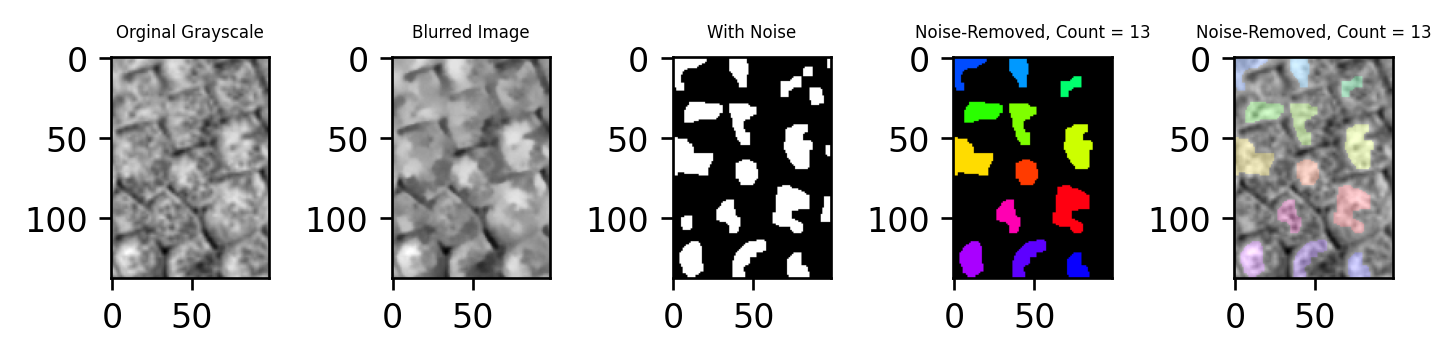

Screenshot 2021-04-29 at 6.29.06 PM_03_02.png
Original Image:
avg shortest distance 13.172638871554177 23.210560888941124
Block size from formula: 54.200943725675174
Blocksize, iterations: 51, 3
Size variation: 0.3213021603018857
Distribution: 5.457821387750994
Overall score: 2.88956177402644

Original image passed all tests; did not need to check inverted.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


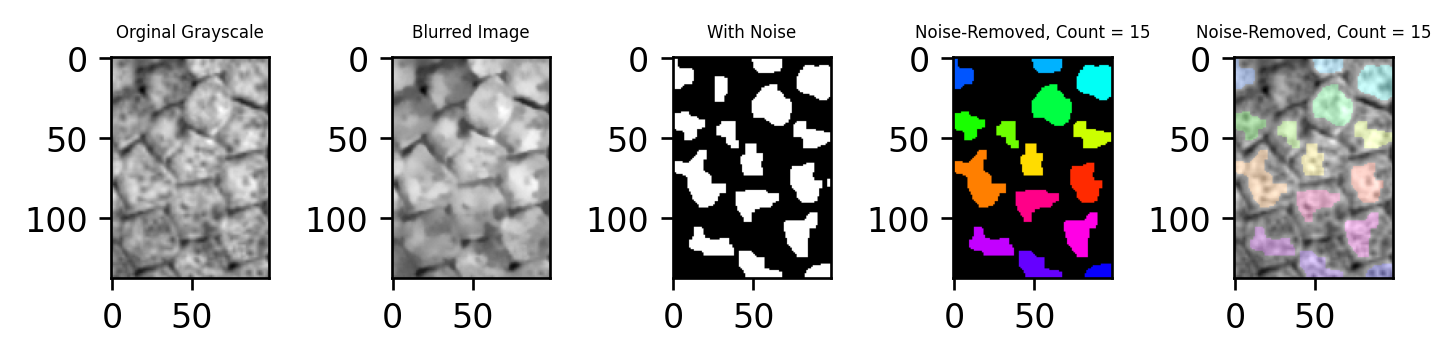

Screenshot 2021-04-29 at 6.29.06 PM_01_04.png
Original Image:
avg shortest distance 6.85287918143244 24.138857197334623
Block size from formula: 45.12959555535281
Blocksize, iterations: 43, 2
Size variation: 0.49221193449986744
Distribution: 6.997663880879224
Overall score: 3.744937907689546

Inverted Image:
avg shortest distance 8.043649202947359 23.399937866190985
Block size from formula: 46.86786020012277
Blocksize, iterations: 45, 3
Size variation: 0.4648572357800451
Distribution: 13.044812395324154
Overall score: 6.754834815552099

Tried both original and inverted, but decided to keep original.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


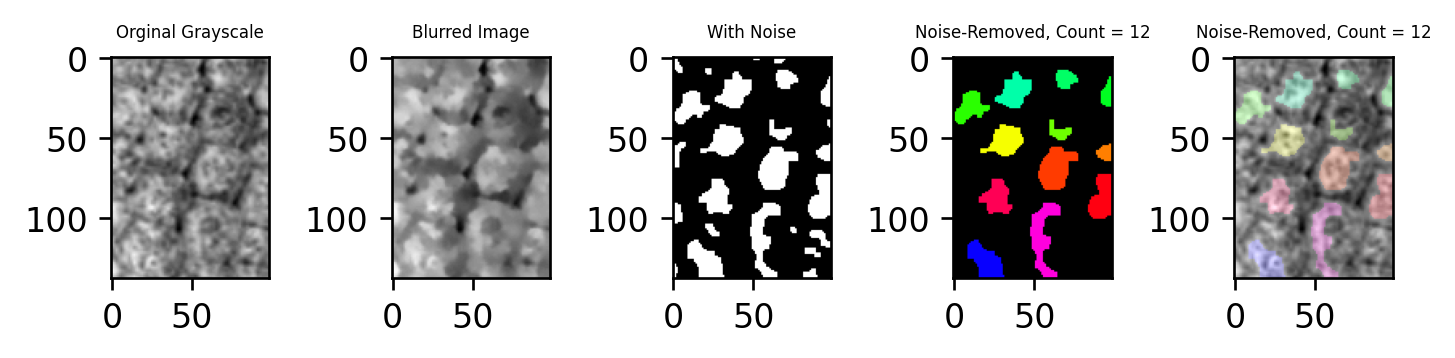

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Screenshot 2021-04-29 at 6.29.06 PM_03_01.png
Original Image:
avg shortest distance 5.077564535357358 29.262051158036204
Block size from formula: 54.68400251639756
Blocksize, iterations: 53, 3
Size variation: 0.3856646511340261
Distribution: 6.782972148810534
Overall score: 3.58431839997228

Inverted Image:
avg shortest distance 9.687781494160912 36.007505158769
Block size from formula: 67.1379471756963
Blocksize, iterations: 65, 3
Size variation: 0.8607217036570033
Distribution: 23.425828015618478
Overall score: 12.14327485963774

Tried both original and inverted, but decided to keep original.


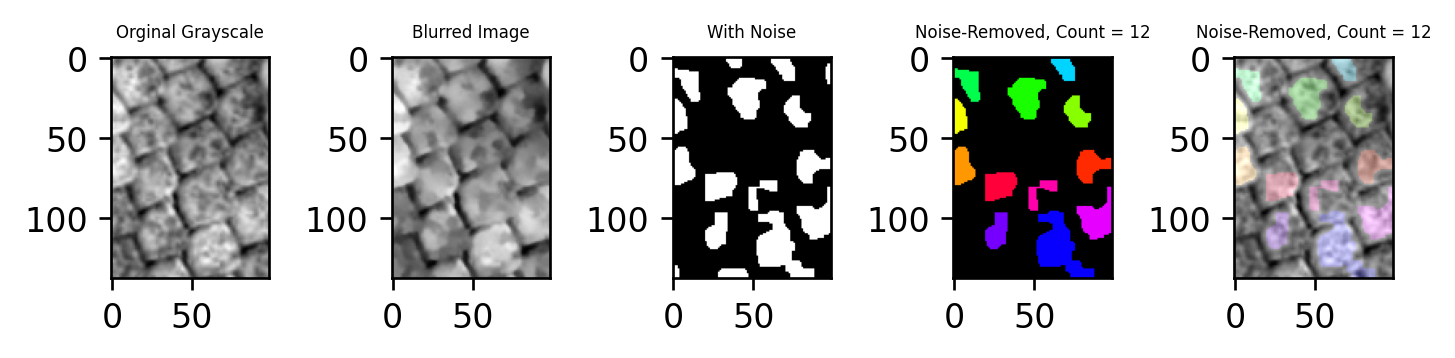

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Screenshot 2021-04-29 at 6.29.06 PM_01_01.png
Original Image:
avg shortest distance 7.823354684814054 21.104890005632218
Block size from formula: 41.461444963342004
Blocksize, iterations: 39, 2
Size variation: 0.19983438454457814
Distribution: 5.547646982426581
Overall score: 2.87374068348558

Original image passed all tests; did not need to check inverted.


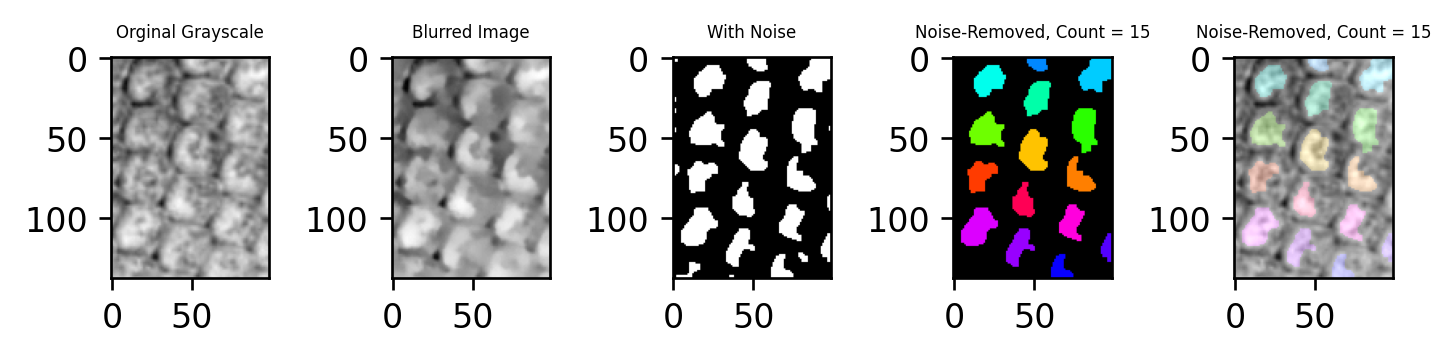

Screenshot 2021-04-29 at 6.29.06 PM_03_04.png
Original Image:
avg shortest distance 6.18183037626448 19.71643121557625
Block size from formula: 35.14029057121612
Blocksize, iterations: 35, 2
Size variation: 0.3656993049880732
Distribution: 5.437913461896634
Overall score: 2.9018063834423535

Original image passed all tests; did not need to check inverted.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


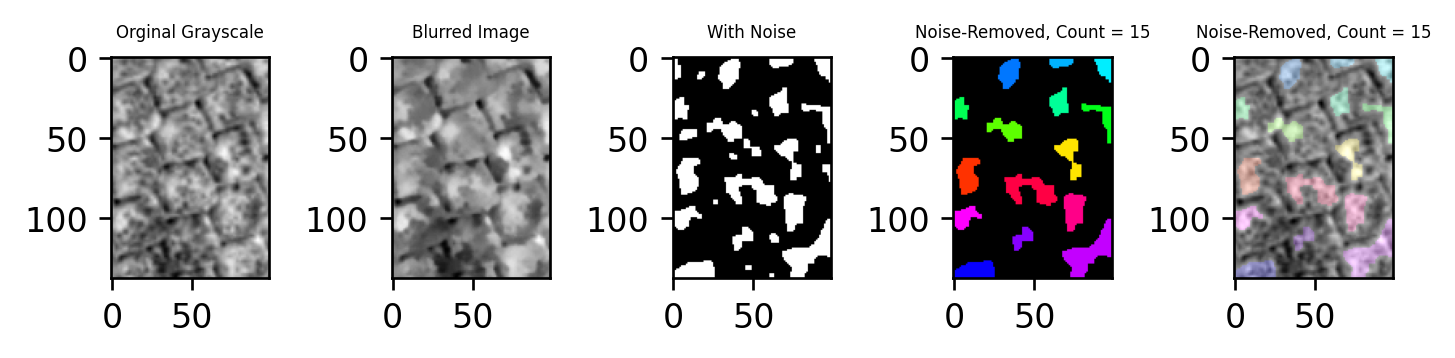

Screenshot 2021-04-29 at 6.29.06 PM_01_03.png
Original Image:
avg shortest distance 9.221837376054411 29.22459330729114
Block size from formula: 48.6227639369681
Blocksize, iterations: 47, 3
Size variation: 0.6348453860136182
Distribution: 8.71973105462586
Overall score: 4.677288220319739

Inverted Image:
avg shortest distance 11.190666690698224 22.767091154446188
Block size from formula: 45.777209917479084
Blocksize, iterations: 43, 2
Size variation: 0.8009765429881887
Distribution: 6.856928430170646
Overall score: 3.8289524865794173

DECIDED TO USE INVERTED IMAGE.


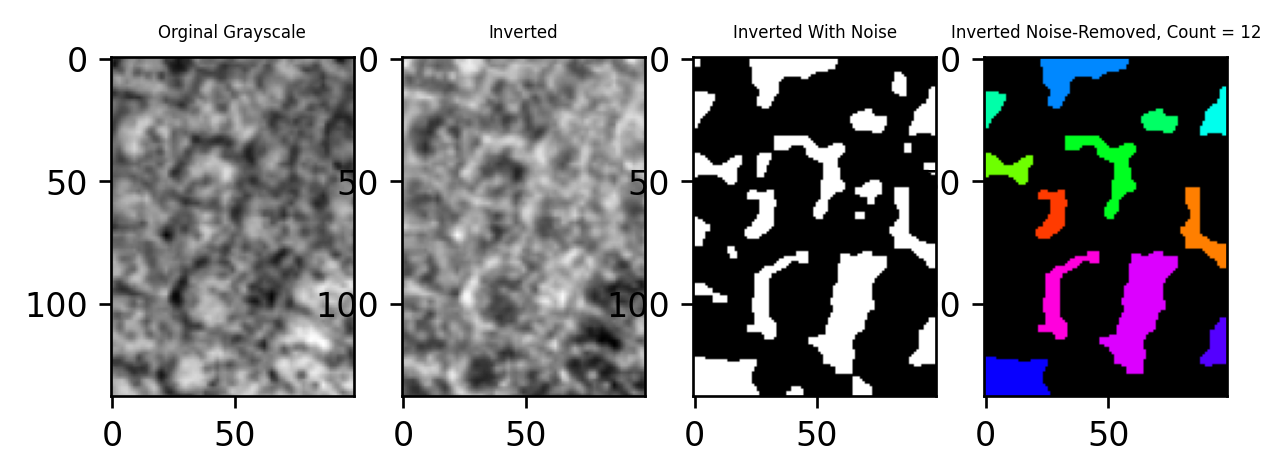

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Screenshot 2021-04-29 at 6.29.06 PM_01_02.png
Original Image:
avg shortest distance 5.396644224738099 23.379915728034405
Block size from formula: 40.54906199315401
Blocksize, iterations: 39, 2
Size variation: 0.19666359235810665
Distribution: 6.10973661360534
Overall score: 3.153200102981723

Inverted Image:
avg shortest distance 11.942017301988693 25.776970152257743
Block size from formula: 40.5245189362397
Blocksize, iterations: 39, 2
Size variation: 1.0064399170347258
Distribution: 10.505377960083532
Overall score: 5.755908938559129

Tried both original and inverted, but decided to keep original.


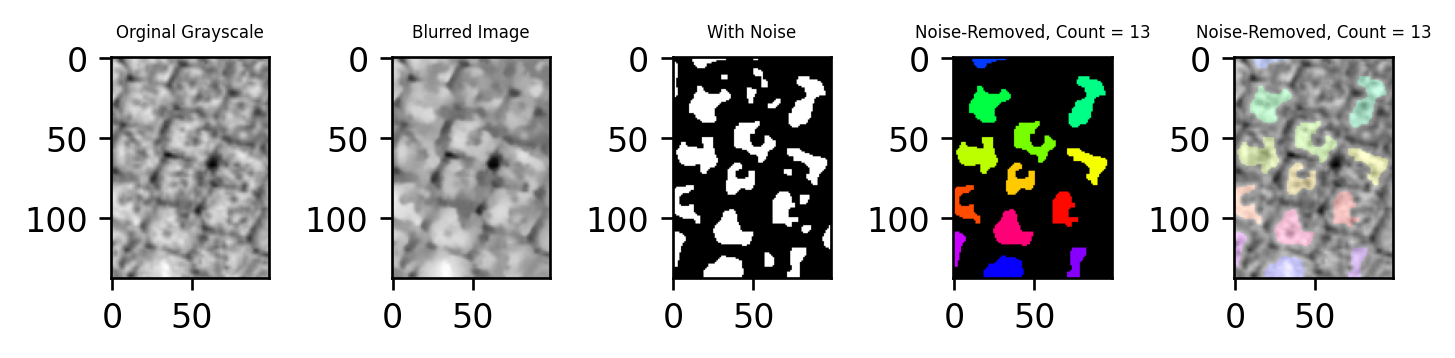

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Screenshot 2021-04-29 at 6.28.01 PM.png
Original Image:
avg shortest distance 11.380385514197881 24.37569955537112
Block size from formula: 42.66143951632316
Blocksize, iterations: 41, 2
Size variation: 1.1489067026905095
Distribution: 1.918694935626394
Overall score: 1.5338008191584518

Original image passed all tests; did not need to check inverted.


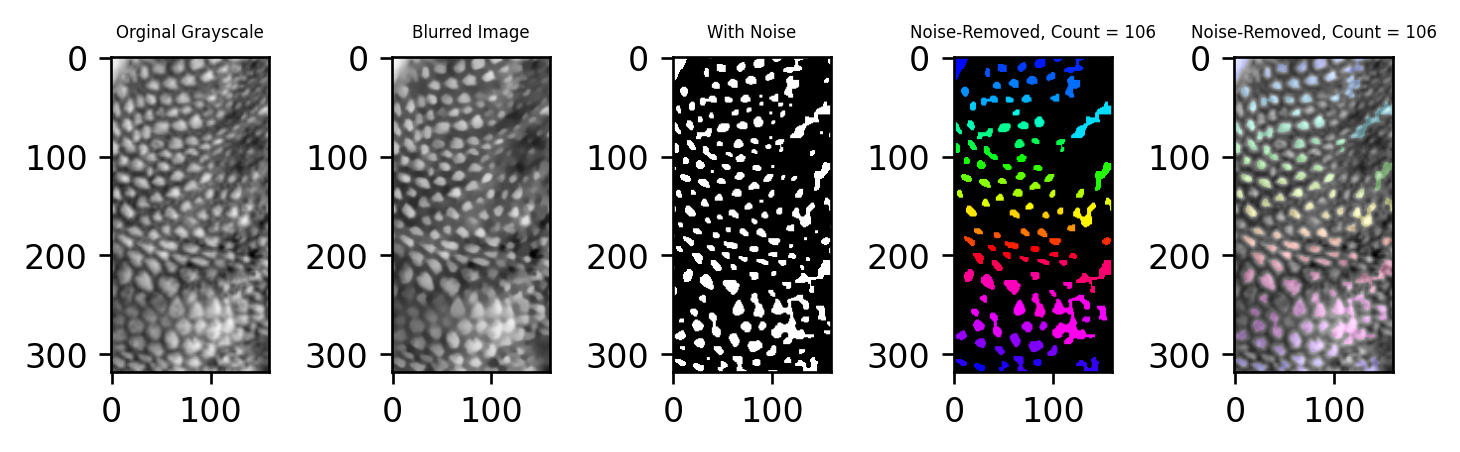

Screenshot 2021-04-29 at 6.28.29 PM.png
Original Image:
avg shortest distance 16.40633474766748 29.617536741051232
Block size from formula: 76.15762282416887
Blocksize, iterations: 73, 3
Size variation: 0.9661998413007912
Distribution: 2.7722842831507455
Overall score: 1.8692420622257684

Original image passed all tests; did not need to check inverted.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


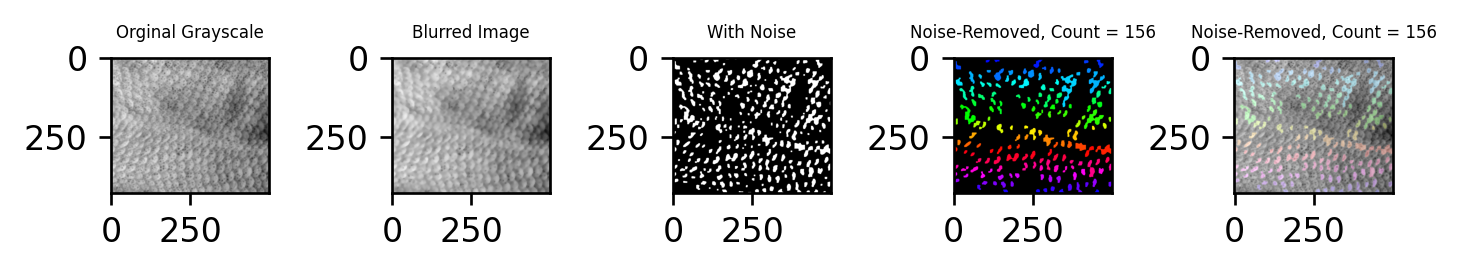

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Screenshot 2021-04-29 at 6.29.06 PM_02_01.png
Original Image:
avg shortest distance 6.583570082571975 25.84882531914122
Block size from formula: 47.34786004299332
Blocksize, iterations: 45, 3
Size variation: 0.18804575922293063
Distribution: 6.182831635072464
Overall score: 3.1854386971476973

Inverted Image:
avg shortest distance 8.804336799177749 22.46926829959103
Block size from formula: 43.85064474424283
Blocksize, iterations: 43, 2
Size variation: 0.685678477151102
Distribution: 8.284943147472632
Overall score: 4.485310812311867

Tried both original and inverted, but decided to keep original.


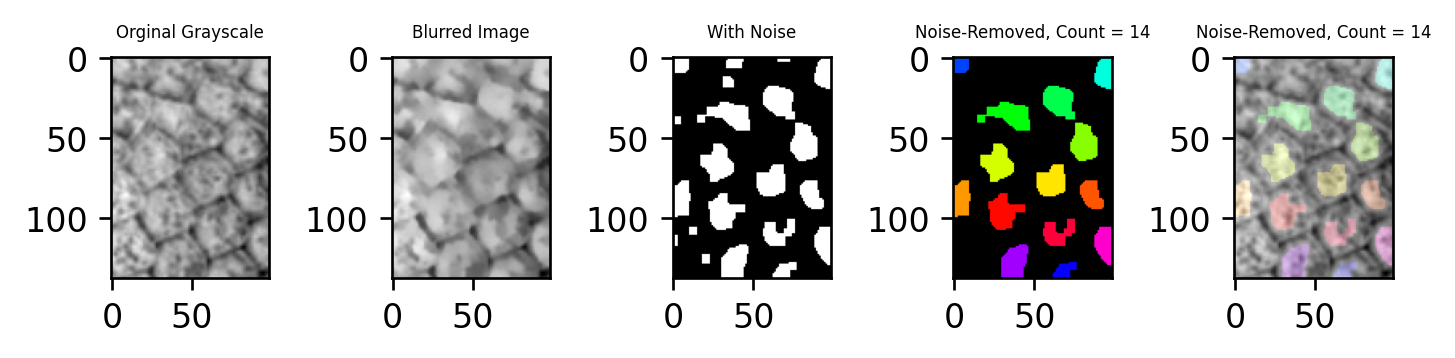

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Screenshot 2021-04-29 at 6.29.06 PM_02_02.png
Original Image:
avg shortest distance 7.399580373255571 23.41133543646943
Block size from formula: 44.49816305585402
Blocksize, iterations: 43, 2
Size variation: 0.2292497687314377
Distribution: 4.289833468298276
Overall score: 2.259541618514857

Original image passed all tests; did not need to check inverted.


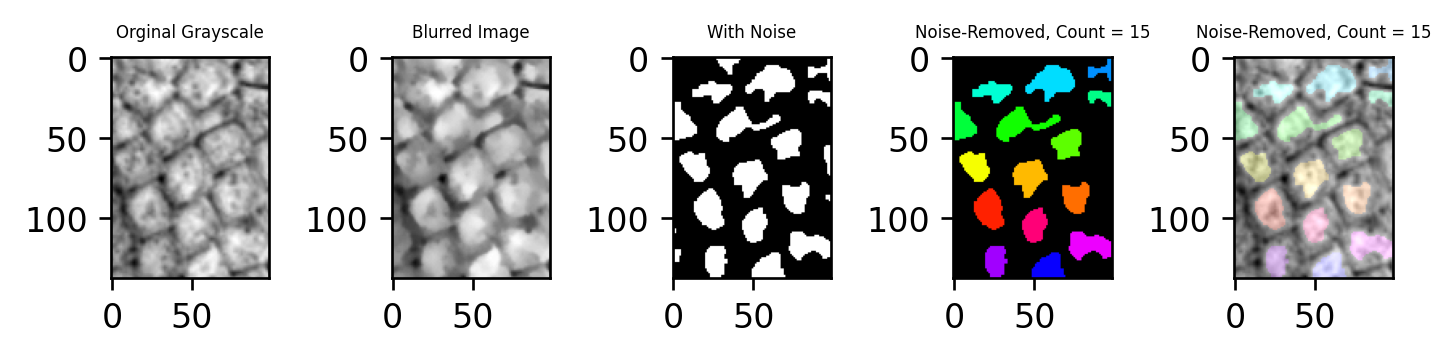

Screenshot 2021-04-29 at 6.29.06 PM_02_03.png
Original Image:
avg shortest distance 12.17839921040213 24.736081145434007
Block size from formula: 49.66652149754637
Blocksize, iterations: 47, 3
Size variation: 0.4164433296306539
Distribution: 6.952733340496384
Overall score: 3.684588335063519

Inverted Image:
avg shortest distance 8.519709276272811 28.36293994507927
Block size from formula: 52.67479433042352
Blocksize, iterations: 51, 3
Size variation: 0.9218184767216405
Distribution: 10.182933296271376
Overall score: 5.552375886496508

Tried both original and inverted, but decided to keep original.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


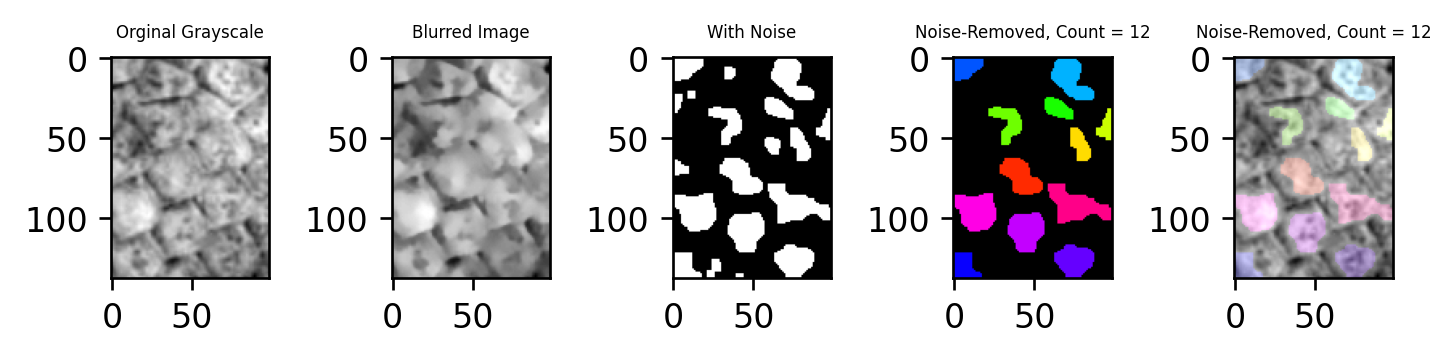

Screenshot 2021-04-29 at 6.29.06 PM_02_04.png
Original Image:
avg shortest distance 17.396371883121695 29.86744610603416
Block size from formula: 53.13853844663592
Blocksize, iterations: 51, 3
Size variation: 0.6053902564808142
Distribution: 7.852717981298049
Overall score: 4.229054118889431

Inverted Image:
avg shortest distance 5.4135689751049565 26.801865125600518
Block size from formula: 51.03934410781457
Blocksize, iterations: 49, 3
Size variation: 0.6334762392549281
Distribution: 15.734757361734875
Overall score: 8.184116800494902

Tried both original and inverted, but decided to keep original.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


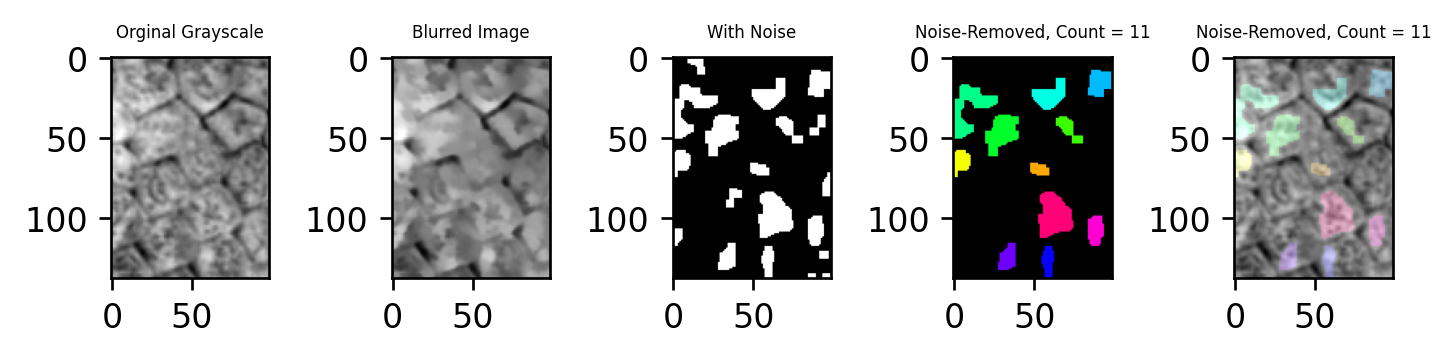

In [34]:
run_count_on_directory('other/')

In [35]:
directory = 'other/Screenshot 2021-04-29 at 6.29.06 PM.png/'

run_count_on_directory(directory)



NotADirectoryError: [Errno 20] Not a directory: 'other/Screenshot 2021-04-29 at 6.29.06 PM.png/'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SUBIMAGE #0:

Original Image:
avg shortest distance 8.690495519578027 20.43906845323335
Block size from formula: 44.633577157784245
Blocksize, iterations: 43, 2
Size variation: 0.22910740095132176
Distribution: 5.606210704668632
Overall score: 2.917659052809977

Original image passed all tests; did not need to check inverted.


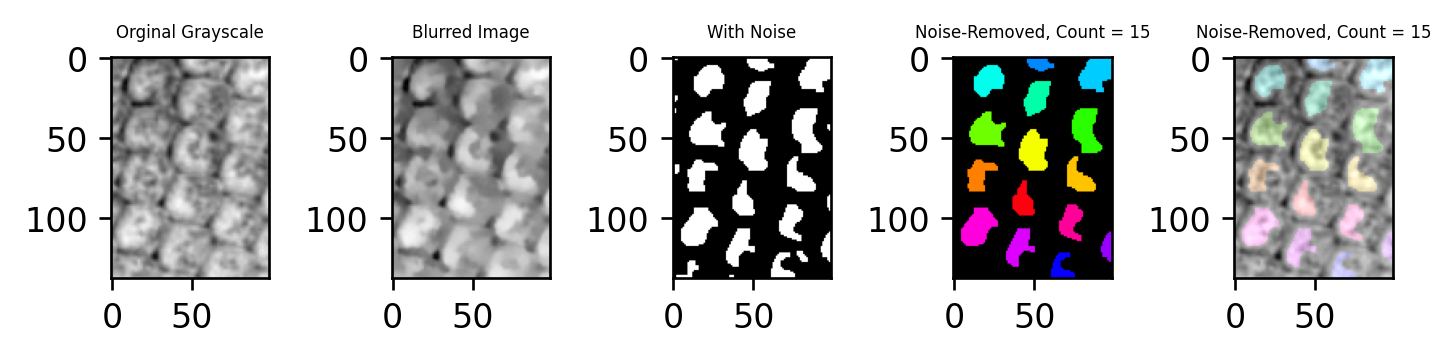

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SUBIMAGE #1:

Original Image:
avg shortest distance 5.943293011804585 21.066389320248234
Block size from formula: 38.36982370832852
Blocksize, iterations: 37, 2
Size variation: 0.3551118700208575
Distribution: 6.300586749327498
Overall score: 3.3278493096741775

Inverted Image:
avg shortest distance 12.606025725876565 27.40871350143931
Block size from formula: 41.55024003918021
Blocksize, iterations: 41, 2
Size variation: 100
Distribution: 13.565290496894361
Overall score: 56.78264524844718

Tried both original and inverted, but decided to keep original.


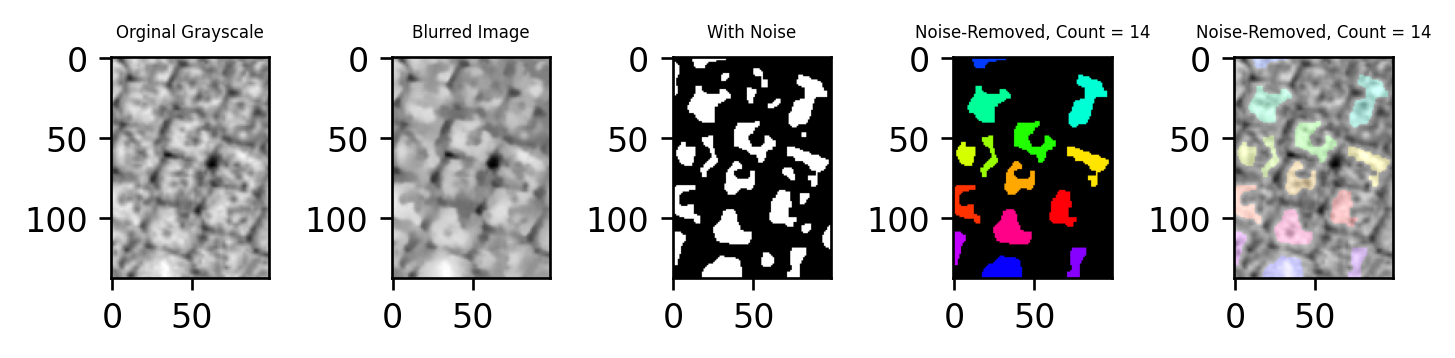

SUBIMAGE #2:

Original Image:
avg shortest distance 8.623685065320219 25.23283850199323
Block size from formula: 44.42767494058461
Blocksize, iterations: 43, 2
Size variation: 0.30356592781648883
Distribution: 7.755196250786911
Overall score: 4.0293810893017

Inverted Image:
avg shortest distance 8.246267089881545 21.120763111374426
Block size from formula: 42.05118418841553
Blocksize, iterations: 41, 2
Size variation: 0.7669474266439752
Distribution: 6.638858902940001
Overall score: 3.702903164791988

DECIDED TO USE INVERTED IMAGE.


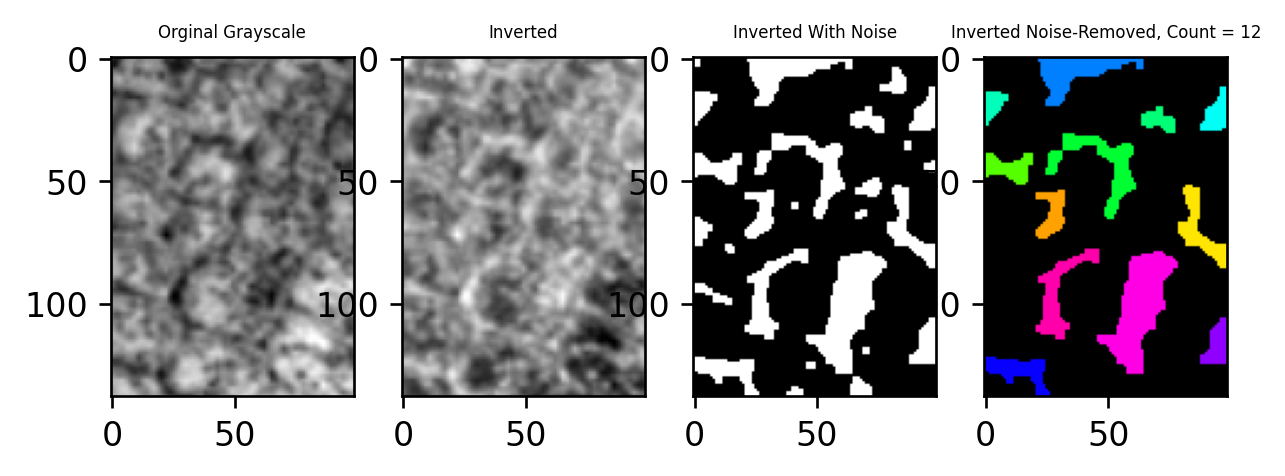

SUBIMAGE #3:

Original Image:
avg shortest distance 6.65709288062353 23.736852805394186
Block size from formula: 45.34560650588993
Blocksize, iterations: 43, 2
Size variation: 0.4288585065046347
Distribution: 7.193436665436243
Overall score: 3.811147585970439

Inverted Image:
avg shortest distance 6.128741501396596 22.544461902532372
Block size from formula: 42.87284114794154
Blocksize, iterations: 41, 2
Size variation: 0.9081037702943736
Distribution: 19.005701232557165
Overall score: 9.95690250142577

Tried both original and inverted, but decided to keep original.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


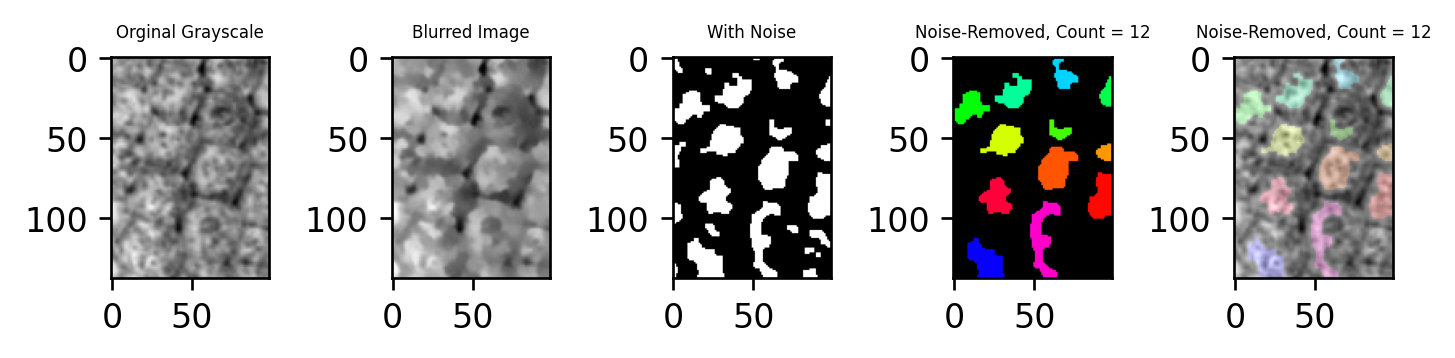

SUBIMAGE #4:

Original Image:
avg shortest distance 7.193204686384039 22.984925013915706
Block size from formula: 44.154496647097744
Blocksize, iterations: 43, 2
Size variation: 0.183234912343607
Distribution: 5.747171942531294
Overall score: 2.9652034274374506

Original image passed all tests; did not need to check inverted.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


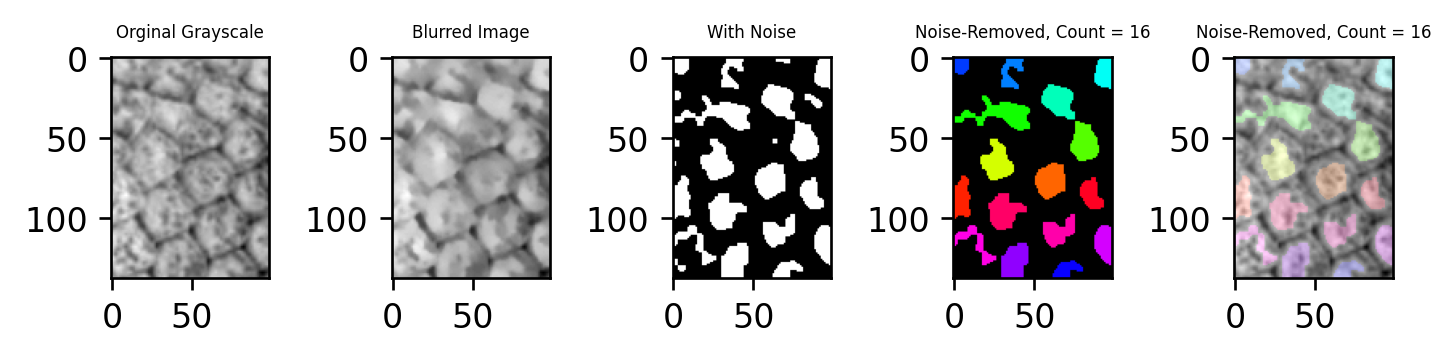

SUBIMAGE #5:

Original Image:
avg shortest distance 8.758593688005499 24.95089797148835
Block size from formula: 46.33955907399543
Blocksize, iterations: 45, 3
Size variation: 0.20420909622362257
Distribution: 3.9428894981966356
Overall score: 2.0735492972101293

Original image passed all tests; did not need to check inverted.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


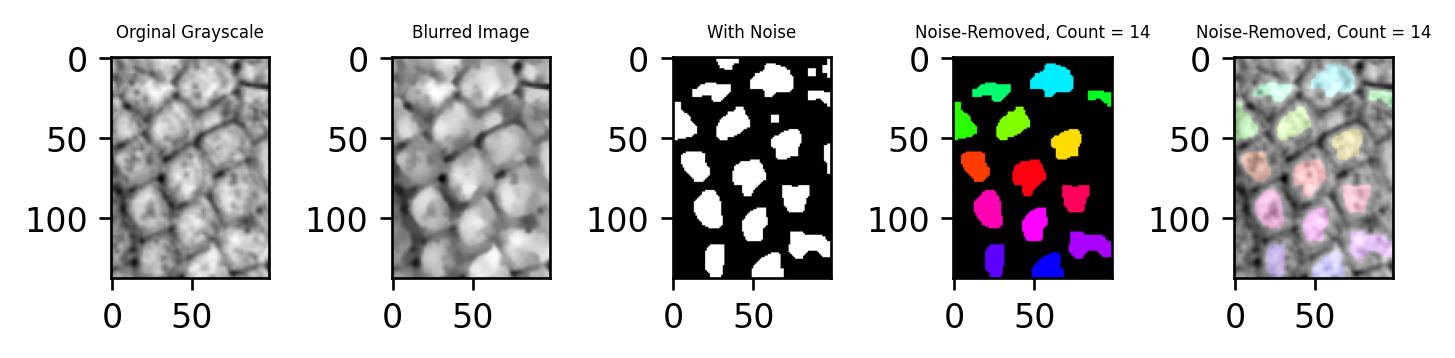

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SUBIMAGE #6:

Original Image:
avg shortest distance 13.788785955989564 32.21155143500618
Block size from formula: 62.551736911833295
Blocksize, iterations: 61, 3
Size variation: 0.35779161854430935
Distribution: 8.039902954478318
Overall score: 4.198847286511314

Inverted Image:
avg shortest distance 9.399029544017488 33.32904822985636
Block size from formula: 60.000616327365634
Blocksize, iterations: 59, 3
Size variation: 0.9328673429772874
Distribution: 9.221960697677591
Overall score: 5.077414020327439

Tried both original and inverted, but decided to keep original.


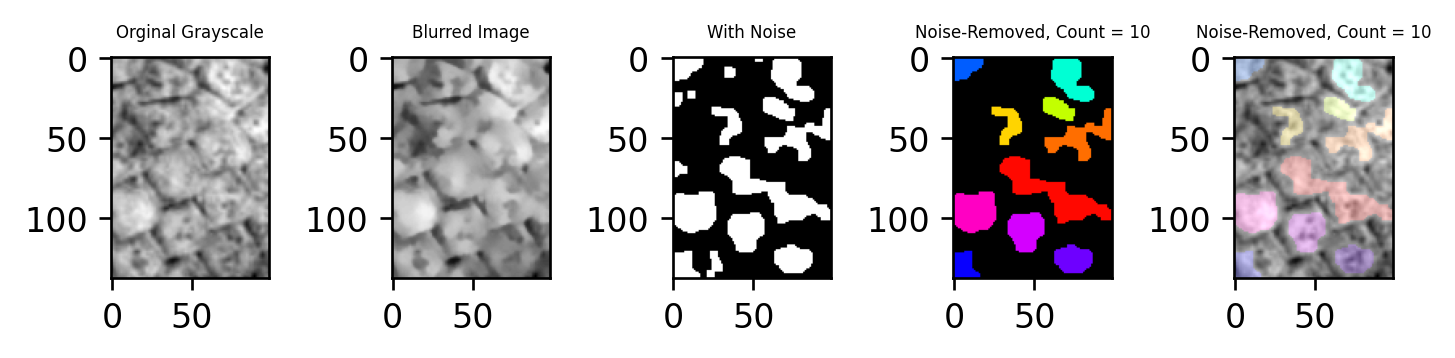

SUBIMAGE #7:

Original Image:
avg shortest distance 16.242838928291835 40.631341920388586
Block size from formula: 65.87594907922617
Blocksize, iterations: 63, 3
Size variation: 0.6511717234328834
Distribution: 10.198915910465587
Overall score: 5.425043816949235

Inverted Image:
avg shortest distance 5.337310064909056 27.27906073606001
Block size from formula: 51.76753988356576
Blocksize, iterations: 49, 3
Size variation: 0.4815536286103637
Distribution: 20.98846149535287
Overall score: 10.735007561981616
Could not find 1 subimages that pass the quality check.

Tried both original and inverted, but decided to keep original.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


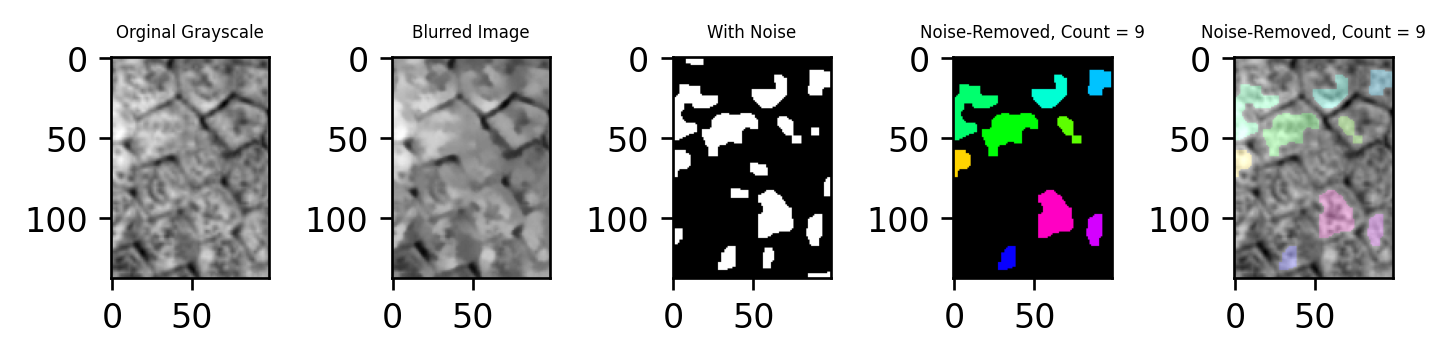

SUBIMAGE #8:

Original Image:
avg shortest distance 5.7057540332236245 29.0451210380423
Block size from formula: 54.819213696775776
Blocksize, iterations: 53, 3
Size variation: 0.34528048792310784
Distribution: 7.300050696897889
Overall score: 3.8226655924104986

Inverted Image:
avg shortest distance 10.121237650149254 51.058158955036234
Block size from formula: 93.58279829169945
Blocksize, iterations: 91, 1

Tried both original and inverted, but decided to keep original.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


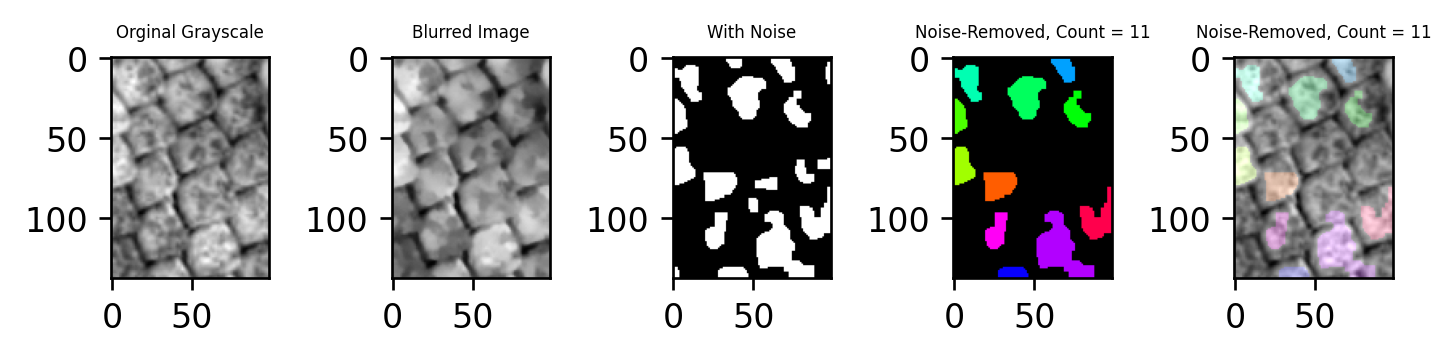

SUBIMAGE #9:

Original Image:
avg shortest distance 9.833364500972012 22.5098342071303
Block size from formula: 48.47344046839805
Blocksize, iterations: 47, 3
Size variation: 0.4232882344609582
Distribution: 5.355859178737461
Overall score: 2.8895737065992098

Original image passed all tests; did not need to check inverted.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


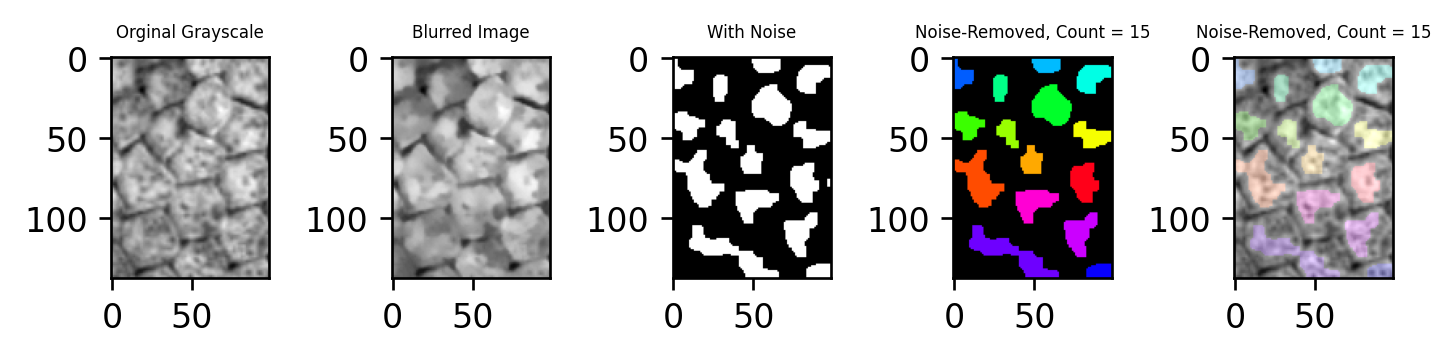

SUBIMAGE #10:

Original Image:
avg shortest distance 14.850649774983989 26.5399835834115
Block size from formula: 50.80325084217311
Blocksize, iterations: 49, 3
Size variation: 0.5701991243562877
Distribution: 7.7920149043014275
Overall score: 4.181107014328858

Inverted Image:
avg shortest distance 4.665288288074627 24.220318520312436
Block size from formula: 44.045624136880264
Blocksize, iterations: 43, 2
Size variation: 100
Distribution: 10.869284760774828
Overall score: 55.434642380387416

Tried both original and inverted, but decided to keep original.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


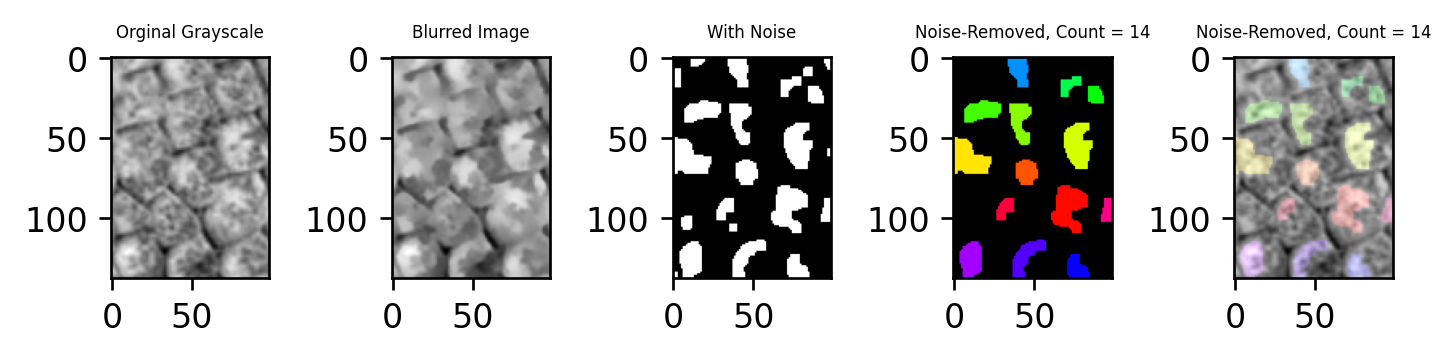

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SUBIMAGE #11:

Original Image:
avg shortest distance 5.652672723000535 21.86048179385611
Block size from formula: 39.180242809863174
Blocksize, iterations: 37, 2
Size variation: 0.4709474763544324
Distribution: 5.472363630624572
Overall score: 2.971655553489502

Original image passed all tests; did not need to check inverted.


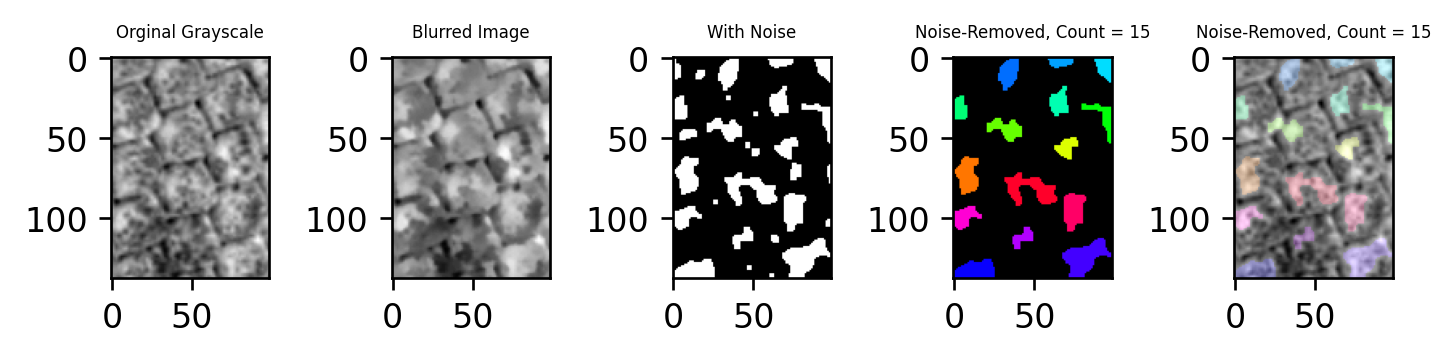

ESTIMATED TOTAL COUNT: 146.66666666666666 SCALES

_______________________________________________

SELECTED SUBIMAGES: [0, 5, 9]


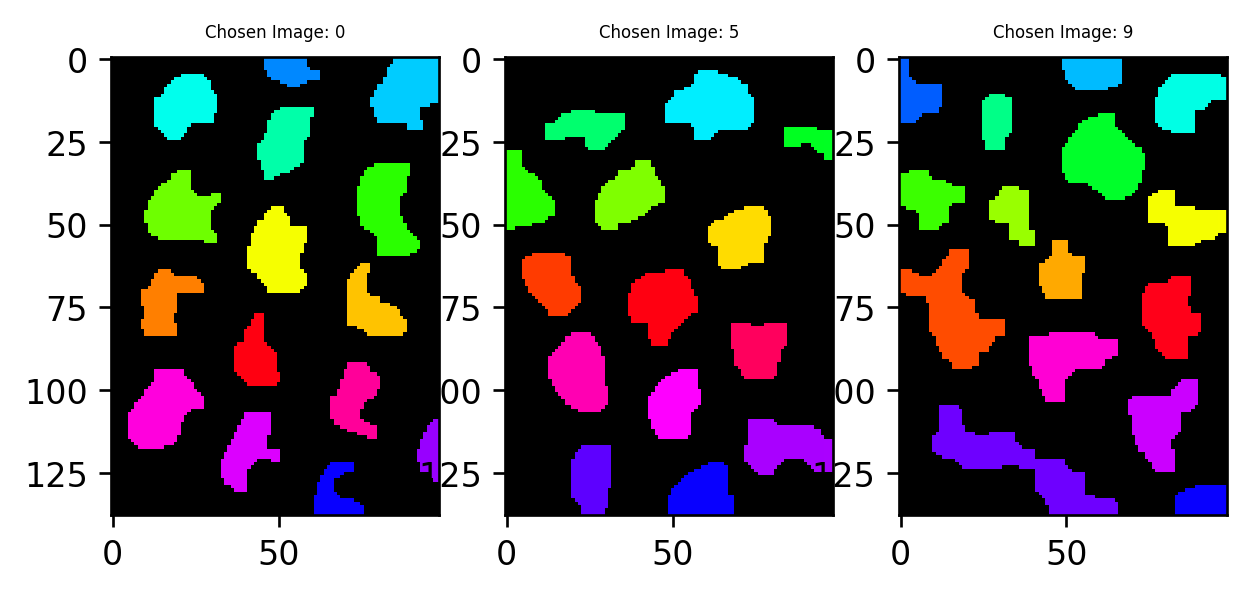

In [36]:
split_count_select('other/Screenshot 2021-04-29 at 6.29.06 PM.png', 10, 3)

In [ ]:
run_count_on_directory('test/')

In [ ]:
run_count_on_directory('Fish_scales/')